In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout, Bidirectional

import warnings
warnings.filterwarnings('ignore')

In [2]:
import ShapTimeRNN
from ShapTimeRNN import supertime, ShapleyValues, TimeImportance, TimeHeatmap, trans, supertime_add

In [3]:
data = pd.read_csv('D:/Papers/paper_code/new/Data/Processed/Climate_data.csv')
data.head()

,date,meantemp,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
0,2013-01-01,0.122271,0.840372,0.000000,0.132603,0.0,0.0,0.000000,0.166667
1,2013-01-02,0.042795,0.929054,0.070583,0.132881,0.0,0.0,0.033333,0.333333
2,2013-01-03,0.035662,0.869932,0.109743,0.132994,0.0,0.0,0.066667,0.500000
3,2013-01-04,0.081514,0.684685,0.029212,0.132799,0.0,0.0,0.100000,0.666667
4,2013-01-05,0.000000,0.867962,0.087636,0.132712,0.0,0.0,0.133333,0.833333


In [4]:
train = data[:-180]
test = data[-180:]
print(train.shape)
print(test.shape)

(1395, 9)
(180, 9)


In [5]:
x_train = train.drop(columns = {'date','meantemp'}, axis = 1)
y_train = train.loc[:, ['meantemp']]

x_test = test.drop(columns = {'date','meantemp'}, axis = 1)
y_test = test.loc[:, ['meantemp']]

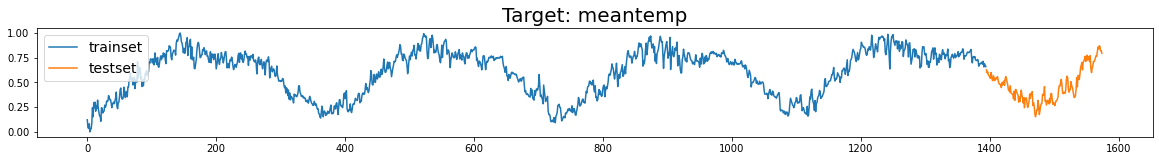

In [6]:
sns.reset_orig()
plt.figure(figsize = (20,2))
plt.title('Target: meantemp', fontsize = 20)
plt.plot(y_train['meantemp'], label = 'trainset')
plt.plot(y_test['meantemp'], label = 'testset')

plt.legend(fontsize = 14)
plt.show()

In [7]:
x_train_sca = x_train.values[:].reshape(x_train.shape[0], 1, x_train.shape[1])
x_test_sca = x_test.values[:].reshape(x_test.shape[0], 1, x_test.shape[1])

# RNN

In [7]:
model_rnn = tf.keras.Sequential([
        SimpleRNN(100, return_sequences=True,activation='relu'), 
        Dropout(0.1), 
        SimpleRNN(100,return_sequences=False),
        Dropout(0.2), 
        Dense(1) ])

model_rnn.compile(loss='mse', optimizer='adam') 
    
history = model_rnn.fit(x_train_sca, y_train, batch_size=64, epochs=100)

Epoch 1/100
22/22 [==============================] - 1s 1ms/step - loss: 0.1338
Epoch 2/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0640
Epoch 3/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0470
Epoch 4/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 5/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0321
Epoch 6/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0271
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0253
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 9/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0208
Epoch 10/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0176
Epoch 11/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0185
Epoch 12/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0173
Epoch 13/100
22/22 [=================

In [8]:
prediction_rnn = model_rnn.predict(x_test_sca)

6/6 [==============================] - 0s 798us/step


In [9]:
r2 = r2_score(prediction_rnn, y_test)
mse = mean_squared_error(prediction_rnn, y_test)
print(r2)
print(mse)

0.7170259123651025
0.010473890568085429


In [20]:
model_rnn.save('model_rnn.h5')

In [11]:
Tn= 8
interp_x= x_train_sca
model = model_rnn

ShapTime_rnn = ShapleyValues(model, interp_x, Tn)

44/44 [==============================] - 0s 533us/step


In [12]:
ShapTime_rnn

[array([-0.00826528], dtype=float32),
 array([0.00332278], dtype=float32),
 array([-0.03403676], dtype=float32),
 array([0.02685584], dtype=float32),
 array([-0.05223121], dtype=float32),
 array([0.04468987], dtype=float32),
 array([-0.0454265], dtype=float32),
 array([0.066141], dtype=float32)]

In [13]:
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7']

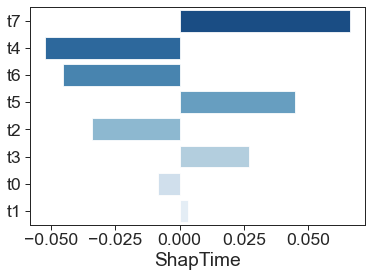

In [14]:
TimeImportance(Tn, trans(ShapTime_rnn), time_columns)

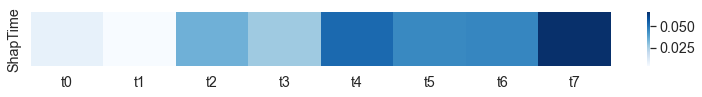

In [15]:
TimeHeatmap(Tn, trans(ShapTime_rnn), time_columns)

### Improvement

In [16]:
for k in range(Tn):
    exec(f't{k} = supertime_add(Tn, train)[k]')

In [17]:
check_replist = [t0, t7, t2, t3, t4, t5, t6, t7]

In [18]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'date','meantemp'}, axis = 1)
y_check = check.loc[:, ['meantemp']]
x_check_sca = x_check.values[:].reshape(x_check.shape[0], 1, x_check.shape[1])


model_check = tf.keras.Sequential([
        SimpleRNN(100, return_sequences=True,activation='relu'), 
        Dropout(0.1), 
        SimpleRNN(100,return_sequences=False),
        Dropout(0.2), 
        Dense(1) ])

model_check.compile(loss='mse', optimizer='adam') 
    
history = model_check.fit(x_check_sca, y_check, batch_size=64, epochs=100)

Epoch 1/100
22/22 [==============================] - 1s 1ms/step - loss: 0.1806
Epoch 2/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0643
Epoch 3/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0482
Epoch 4/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 5/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0334
Epoch 6/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0321
Epoch 7/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0248
Epoch 8/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 9/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0190
Epoch 10/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0194
Epoch 11/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 12/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0163
Epoch 13/100
22/22 [=================

In [19]:
pred_check = model_check.predict(x_test_sca)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

6/6 [==============================] - 0s 999us/step
0.7255626116888679 Degree of Improvement: 1.19%
0.009598447614709791 Degree of Improvement: 8.36%


In [21]:
model_check.save('model_(rnn).h5')

# Bi-RNN

In [39]:
model_birnn = tf.keras.Sequential([
        Bidirectional(SimpleRNN(100, return_sequences=True,activation='relu')), 
        Dropout(0.1),
        Bidirectional(SimpleRNN(100, return_sequences=True,activation='relu')),
        Dropout(0.2),
        Dense(1) ])

model_birnn.compile(loss='mse', optimizer='adam') 
    
history = model_birnn.fit(x_train_sca, y_train, batch_size=64, epochs=100)

Epoch 1/100
22/22 [==============================] - 2s 2ms/step - loss: 0.1084
Epoch 2/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0539
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0428
Epoch 4/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0349
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch 6/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 10/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 11/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 12/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 13/100
22/22 [=================

In [40]:
prediction_birnn = model_birnn.predict(x_test_sca)

6/6 [==============================] - 0s 2ms/step


In [41]:
prediction_birnn = prediction_birnn.reshape(180, 1)

In [42]:
r2 = r2_score(prediction_birnn, y_test)
mse = mean_squared_error(prediction_birnn, y_test)
print(r2)
print(mse)

0.7257468886712102
0.010249477546663468


In [52]:
model_birnn.save('model_birnn.h5')

In [43]:
Tn= 8
interp_x= x_train_sca
model = model_birnn

ShapTime_birnn = ShapleyValues(model, interp_x, Tn)

44/44 [==============================] - 0s 891us/step


In [44]:
ShapTime_birnn

[array([[-0.01489088]], dtype=float32),
 array([[0.00892797]], dtype=float32),
 array([[-0.04176017]], dtype=float32),
 array([[0.0350752]], dtype=float32),
 array([[-0.05760214]], dtype=float32),
 array([[0.05089223]], dtype=float32),
 array([[-0.04956737]], dtype=float32),
 array([[0.07006325]], dtype=float32)]

In [45]:
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7']

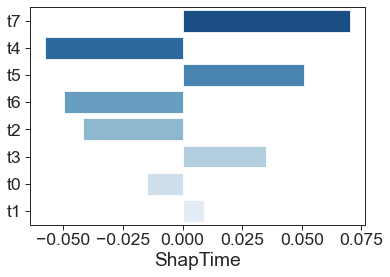

In [46]:
TimeImportance(Tn, trans(ShapTime_birnn), time_columns)

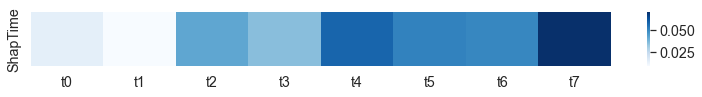

In [47]:
TimeHeatmap(Tn, trans(ShapTime_birnn), time_columns)

### improvement

In [48]:
for k in range(Tn):
    exec(f't{k} = supertime_add(Tn, train)[k]')

In [49]:
check_replist = [t0, t7, t2, t3, t4, t5, t6, t7]

In [50]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'date','meantemp'}, axis = 1)
y_check = check.loc[:, ['meantemp']]
x_check_sca = x_check.values[:].reshape(x_check.shape[0], 1, x_check.shape[1])


model_check = tf.keras.Sequential([
        Bidirectional(SimpleRNN(100, return_sequences=True,activation='relu')), 
        Dropout(0.1),
        Bidirectional(SimpleRNN(100, return_sequences=True,activation='relu')),
        Dropout(0.2),
        Dense(1) ])

model_check.compile(loss='mse', optimizer='adam') 
    
history = model_check.fit(x_check_sca, y_check, batch_size=64, epochs=100)

Epoch 1/100
22/22 [==============================] - 2s 2ms/step - loss: 0.1146
Epoch 2/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0347
Epoch 4/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0279
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 6/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 9/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 10/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 11/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 12/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 13/100
22/22 [=================

In [51]:
pred_check = model_check.predict(x_test_sca)
pred_check = pred_check.reshape(180, 1)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

6/6 [==============================] - 1s 2ms/step
0.7428898124884911 Degree of Improvement: 2.36%
0.008200173821776739 Degree of Improvement: 19.99%


In [53]:
model_check.save('model_(birnn).h5')

# LSTM

In [37]:
model_lstm = tf.keras.Sequential([
        LSTM(100, return_sequences=True,activation='relu'), 
        Dropout(0.1), 
        LSTM(100,return_sequences=False),
        Dropout(0.2), 
        Dense(1) ])

model_lstm.compile(loss='mse', optimizer='adam') 
    
history = model_lstm.fit(x_train_sca, y_train, batch_size=64, epochs=100)

Epoch 1/100
22/22 [==============================] - 2s 4ms/step - loss: 0.3048
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0874
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0593
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0526
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0463
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0421
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0379
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0351
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0354
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0326
Epoch 11/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0317
Epoch 12/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0296
Epoch 13/100
22/22 [=================

In [38]:
prediction_lstm = model_lstm.predict(x_test_sca)

6/6 [==============================] - 0s 443us/step


In [39]:
r2 = r2_score(prediction_lstm, y_test)
mse = mean_squared_error(prediction_lstm, y_test)
print(r2)
print(mse)

0.7507274618066053
0.008149744067640631


In [49]:
model_lstm.save('model_lstm.h5')

In [40]:
Tn= 8
interp_x= x_train_sca
model = model_lstm

ShapTime_lstm = ShapleyValues(model, interp_x, Tn)

44/44 [==============================] - 0s 786us/step


In [41]:
ShapTime_lstm

[array([-0.01518478], dtype=float32),
 array([0.00370967], dtype=float32),
 array([-0.03868419], dtype=float32),
 array([0.0289395], dtype=float32),
 array([-0.05164529], dtype=float32),
 array([0.04902559], dtype=float32),
 array([-0.04371884], dtype=float32),
 array([0.06850641], dtype=float32)]

In [42]:
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7']

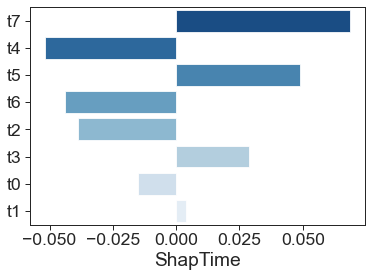

In [43]:
TimeImportance(Tn, trans(ShapTime_lstm), time_columns)

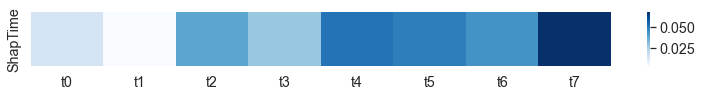

In [44]:
TimeHeatmap(Tn, trans(ShapTime_lstm), time_columns)

In [45]:
for k in range(Tn):
    exec(f't{k} = supertime_add(Tn, train)[k]')

In [46]:
check_replist = [t0, t7, t2, t3, t4, t5, t6, t7]

In [47]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'date','meantemp'}, axis = 1)
y_check = check.loc[:, ['meantemp']]
x_check_sca = x_check.values[:].reshape(x_check.shape[0], 1, x_check.shape[1])


model_check = tf.keras.Sequential([
        LSTM(100, return_sequences=True,activation='relu'), 
        Dropout(0.1), 
        LSTM(100,return_sequences=False),
        Dropout(0.2), 
        Dense(1) ])

model_check.compile(loss='mse', optimizer='adam') 
    
history = model_check.fit(x_check_sca, y_check, batch_size=64, epochs=100)

Epoch 1/100
22/22 [==============================] - 3s 4ms/step - loss: 0.3138
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0799
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0544
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0475
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0432
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0386
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0356
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0332
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0320
Epoch 10/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 11/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0299
Epoch 12/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0289
Epoch 13/100
22/22 [=================

In [48]:
pred_check = model_check.predict(x_test_sca)
pred_check = pred_check.reshape(180, 1)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

6/6 [==============================] - 0s 2ms/step
0.7751390155944299 Degree of Improvement: 3.25%
0.007005737190805878 Degree of Improvement: 14.04%


In [50]:
model_check.save('model_(lstm).h5')

# Bi-LSTM

In [44]:
model_bilstm = tf.keras.Sequential([
        Bidirectional(LSTM(100, return_sequences=True,activation='relu')), 
        Dropout(0.1),
        Bidirectional(LSTM(100, return_sequences=True,activation='relu')),
        Dropout(0.2),
        Dense(1) ])

model_bilstm.compile(loss='mse', optimizer='adam') 
    
history = model_bilstm.fit(x_train_sca, y_train, batch_size=64, epochs=100)

Epoch 1/100
22/22 [==============================] - 4s 8ms/step - loss: 0.3140
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0878
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0588
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0508
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0438
Epoch 6/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0370
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0322
Epoch 8/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0296
Epoch 9/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0262
Epoch 10/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0235
Epoch 11/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0215
Epoch 12/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0203
Epoch 13/100
22/22 [=================

In [45]:
prediction_bilstm = model_bilstm.predict(x_test_sca)
prediction_bilstm = prediction_bilstm.reshape(180, 1)

6/6 [==============================] - 0s 3ms/step


In [46]:
r2 = r2_score(prediction_bilstm, y_test)
mse = mean_squared_error(prediction_bilstm, y_test)
print(r2)
print(mse)

0.6903101121873791
0.010338552187223866


In [56]:
model_bilstm.save('model_bilstm.h5')

In [47]:
Tn= 8
interp_x= x_train_sca
model = model_bilstm

ShapTime_bilstm = ShapleyValues(model, interp_x, Tn)

44/44 [==============================] - 0s 1ms/step


In [48]:
ShapTime_bilstm

[array([[-0.01335004]], dtype=float32),
 array([[0.00441032]], dtype=float32),
 array([[-0.03811049]], dtype=float32),
 array([[0.02893588]], dtype=float32),
 array([[-0.05196895]], dtype=float32),
 array([[0.04749242]], dtype=float32),
 array([[-0.04346962]], dtype=float32),
 array([[0.06699549]], dtype=float32)]

In [49]:
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7']

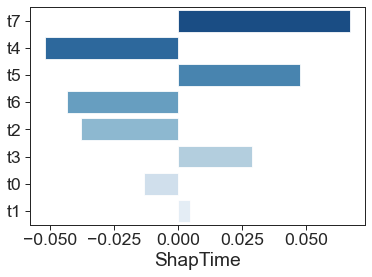

In [50]:
TimeImportance(Tn, trans(ShapTime_bilstm), time_columns)

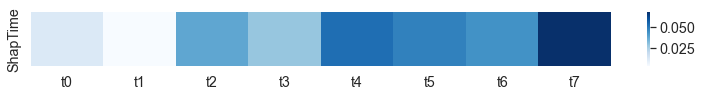

In [51]:
TimeHeatmap(Tn, trans(ShapTime_bilstm), time_columns)

In [52]:
for k in range(Tn):
    exec(f't{k} = supertime_add(Tn, train)[k]')

In [53]:
check_replist = [t0, t7, t2, t3, t4, t5, t6, t7]

In [54]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'date','meantemp'}, axis = 1)
y_check = check.loc[:, ['meantemp']]
x_check_sca = x_check.values[:].reshape(x_check.shape[0], 1, x_check.shape[1])


model_check = tf.keras.Sequential([
        Bidirectional(LSTM(100, return_sequences=True,activation='relu')), 
        Dropout(0.1),
        Bidirectional(LSTM(100, return_sequences=True,activation='relu')),
        Dropout(0.2),
        Dense(1) ])

model_check.compile(loss='mse', optimizer='adam') 
    
history = model_check.fit(x_check_sca, y_check, batch_size=64, epochs=100)

Epoch 1/100
22/22 [==============================] - 4s 13ms/step - loss: 0.3061
Epoch 2/100
22/22 [==============================] - 0s 14ms/step - loss: 0.0755
Epoch 3/100
22/22 [==============================] - 0s 14ms/step - loss: 0.0566
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.0474
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 0.0406
Epoch 6/100
22/22 [==============================] - 0s 14ms/step - loss: 0.0344
Epoch 7/100
22/22 [==============================] - 0s 14ms/step - loss: 0.0303
Epoch 8/100
22/22 [==============================] - 0s 14ms/step - loss: 0.0277
Epoch 9/100
22/22 [==============================] - 0s 14ms/step - loss: 0.0254
Epoch 10/100
22/22 [==============================] - 0s 14ms/step - loss: 0.0224
Epoch 11/100
22/22 [==============================] - 0s 14ms/step - loss: 0.0201
Epoch 12/100
22/22 [==============================] - 0s 14ms/step - loss: 0.0181
Epoch 13/100
22/22 [=====

In [55]:
pred_check = model_check.predict(x_test_sca)
pred_check = pred_check.reshape(180, 1)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

6/6 [==============================] - 0s 2ms/step
0.7532708139543882 Degree of Improvement: 9.12%
0.00844948271952282 Degree of Improvement: 18.27%


In [57]:
model_check.save('model_(bilstm).h5')

# GRU

In [20]:
model_gru = tf.keras.Sequential([
        GRU(100, return_sequences=True,activation='relu'), 
        Dropout(0.1), 
        GRU(100,return_sequences=False),
        Dropout(0.2), 
        Dense(1) ])

model_gru.compile(loss='mse', optimizer='adam') 
    
history = model_gru.fit(x_train_sca, y_train, batch_size=64, epochs=100)

Epoch 1/100
22/22 [==============================] - 3s 2ms/step - loss: 0.1855
Epoch 2/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0613
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0487
Epoch 4/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0438
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0372
Epoch 6/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0332
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0291
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0281
Epoch 9/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0259
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0240
Epoch 11/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 12/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 13/100
22/22 [=================

In [21]:
prediction_gru = model_gru.predict(x_test_sca)

6/6 [==============================] - 0s 1ms/step


In [22]:
r2 = r2_score(prediction_gru, y_test)
mse = mean_squared_error(prediction_gru, y_test)
print(r2)
print(mse)

0.6719010913023766
0.011761116453606996


In [31]:
model_gru.save('model_gru.h5')

In [23]:
Tn= 8
interp_x= x_train_sca
model = model_gru

ShapTime_gru = ShapleyValues(model, interp_x, Tn)

44/44 [==============================] - 0s 738us/step


In [24]:
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7']

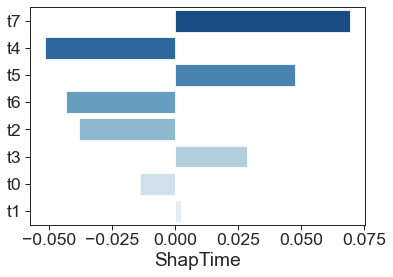

In [25]:
TimeImportance(Tn, trans(ShapTime_gru), time_columns)

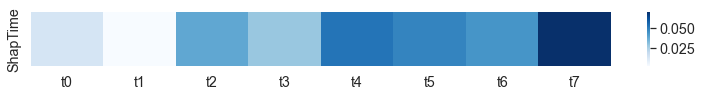

In [26]:
TimeHeatmap(Tn, trans(ShapTime_gru), time_columns)

In [27]:
for k in range(Tn):
    exec(f't{k} = supertime_add(Tn, train)[k]')

In [28]:
check_replist = [t0, t7, t2, t3, t4, t5, t6, t7]

In [29]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'date','meantemp'}, axis = 1)
y_check = check.loc[:, ['meantemp']]
x_check_sca = x_check.values[:].reshape(x_check.shape[0], 1, x_check.shape[1])


model_check = tf.keras.Sequential([
        GRU(100, return_sequences=True,activation='relu'), 
        Dropout(0.1), 
        GRU(100,return_sequences=False),
        Dropout(0.2), 
        Dense(1) ])

model_check.compile(loss='mse', optimizer='adam') 
    
history = model_check.fit(x_check_sca, y_check, batch_size=64, epochs=100)

Epoch 1/100
22/22 [==============================] - 3s 3ms/step - loss: 0.2231
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0596
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0472
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0404
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0350
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0277
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0258
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0236
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0212
Epoch 11/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 12/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 13/100
22/22 [=================

In [30]:
pred_check = model_check.predict(x_test_sca)
pred_check = pred_check.reshape(180, 1)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

6/6 [==============================] - 0s 2ms/step
0.7470031517204349 Degree of Improvement: 11.18%
0.009200394883230212 Degree of Improvement: 21.77%


In [32]:
model_check.save('model_(gru).h5')

# Bi-GRU

In [42]:
model_bigru = tf.keras.Sequential([
        Bidirectional(GRU(100, return_sequences=True,activation='relu')), 
        Dropout(0.1),
        Bidirectional(GRU(100, return_sequences=True,activation='relu')),
        Dropout(0.2),
        Dense(1) ])

model_bigru.compile(loss='mse', optimizer='adam') 
    
history = model_bigru.fit(x_train_sca, y_train, batch_size=64, epochs=100)

Epoch 1/100
22/22 [==============================] - 4s 4ms/step - loss: 0.1650
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0607
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0459
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0368
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0297
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0257
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0181
Epoch 9/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0161
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0138
Epoch 11/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 12/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0100
Epoch 13/100
22/22 [=================

In [43]:
prediction_bigru = model_bigru.predict(x_test_sca)
prediction_bigru = prediction_bigru.reshape(180, 1)

6/6 [==============================] - 1s 3ms/step


In [44]:
r2 = r2_score(prediction_bigru, y_test)
mse = mean_squared_error(prediction_bigru, y_test)
print(r2)
print(mse)

0.7136634610748822
0.010948890660267881


In [53]:
model_bigru.save('model_bigru.h5')

In [45]:
Tn= 8
interp_x= x_train_sca
model = model_bigru

ShapTime_bigru = ShapleyValues(model, interp_x, Tn)

44/44 [==============================] - 0s 1ms/step


In [46]:
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7']

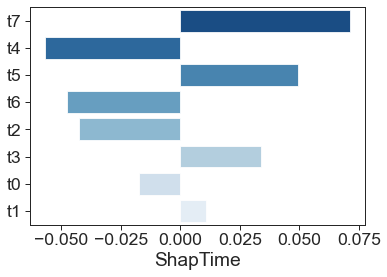

In [47]:
TimeImportance(Tn, trans(ShapTime_bigru), time_columns)

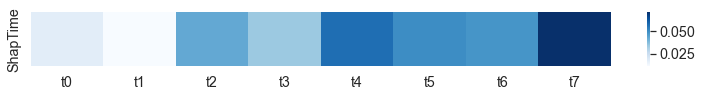

In [48]:
TimeHeatmap(Tn, trans(ShapTime_bigru), time_columns)

In [49]:
for k in range(Tn):
    exec(f't{k} = supertime_add(Tn, train)[k]')

In [50]:
check_replist = [t0, t7, t2, t3, t4, t5, t6, t7]

In [51]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'date','meantemp'}, axis = 1)
y_check = check.loc[:, ['meantemp']]
x_check_sca = x_check.values[:].reshape(x_check.shape[0], 1, x_check.shape[1])


model_check = tf.keras.Sequential([
        Bidirectional(GRU(100, return_sequences=True,activation='relu')), 
        Dropout(0.1),
        Bidirectional(GRU(100, return_sequences=True,activation='relu')),
        Dropout(0.2),
        Dense(1) ])

model_check.compile(loss='mse', optimizer='adam') 
    
history = model_check.fit(x_check_sca, y_check, batch_size=64, epochs=100)

Epoch 1/100
22/22 [==============================] - 4s 7ms/step - loss: 0.1786
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0585
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0419
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0332
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0285
Epoch 6/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0246
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0209
Epoch 8/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0182
Epoch 9/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 10/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 11/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0118
Epoch 12/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0109
Epoch 13/100
22/22 [=================

In [52]:
pred_check = model_check.predict(x_test_sca)
pred_check = pred_check.reshape(180, 1)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

6/6 [==============================] - 0s 2ms/step
0.7412760960683242 Degree of Improvement: 3.87%
0.010032092405702254 Degree of Improvement: 8.37%


In [54]:
model_check.save('model_(bigru).h5')